In [1]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torch.nn.functional as F
import pandas as pd
%matplotlib inline

from utils import read_h5py_folder, augment, resize_fast, get_train_test_data, tumor_data_np, plot_confusion_matrix

/home/dolorousrtur/anaconda3/envs/dipstereo/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [ ]:
# data=read_h5py_folder(path='data/brainTumorDataPublic_1-766', indicies=(0,766))
# data1=read_h5py_folder(path='data/brainTumorDataPublic_767-1532', indicies=(0,766))
# data2=read_h5py_folder(path='data/brainTumorDataPublic_1533-2298', indicies=(0,766))
# data3=read_h5py_folder(path='data/brainTumorDataPublic_2299-3064', indicies=(0,766))

In [ ]:
# data = pd.concat([data,data1,data2,data3],axis=0,ignore_index=True) #merge into one dataframe
# del data1,data2,data3

In [ ]:
# data_resized = resize_fast(data, 64)

In [ ]:
import h5py
from sklearn.model_selection import train_test_split

f = h5py.File('h5.mat')

images = np.expand_dims(f['image'][()], axis=1)
masks = f['tumorMask'][()]
labels = f['label'][()].astype(np.int32)

images_train, images_test, labels_train, labels_test = train_test_split(images, labels)

In [ ]:
train_data = tumor_data_np(images_train, labels_train)
test_data = tumor_data_np(images_test, labels_test)

batch_size, n_iters = 25, 700
n_epoches = int(n_iters / (len(train_data)/batch_size))

train_feeder = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_feeder = torch.utils.data.DataLoader(dataset=test_data, batch_size=1, shuffle=False)



In [ ]:
def squash(x, dim=-1):
    squared_norm = (x**2).sum(dim=dim, keepdim=True)
#     out = (squared_norm * x) / ((1 + squared_norm) * torch.sqrt(squared_norm))
    return (x * squared_norm) / ((1 + squared_norm) * torch.sqrt(squared_norm))

In [ ]:
class PrimaryCaps(torch.nn.Module):
    def __init__(self, in_channels, out_channels, num_capsules):
        super(PrimaryCaps, self).__init__()
        self.capsules = nn.ModuleList()
        
        for i in range(num_capsules):
            self.capsules.append(nn.Conv2d(in_channels, out_channels, 9, stride=2))
            
    def forward(self, x):
        out = []
        for cap in self.capsules:
            out.append(cap(x))
        
        out = torch.cat(out)
        out = torch.stack(out, dim=1)
        out = out.view(x.size()[0], len(self.capsules), -1)
        out = out.permute(0,2,1)
        out = squash(out, dim=-1)
        
        return out

In [ ]:
class ClassesCaps(torch.nn.Module):
    def __init__(self, in_channels, out_channels, in_vectors, n_capsules, n_iters):
        super(ClassesCaps, self).__init__()
        
        self.weights = nn.Parameter(torch.randn(n_capsules, in_vectors, in_channels, out_channels))
        self.n_iters = n_iters
        
    def forward(self, x):
        predictions = x[None, :, :, None, :] @ self.weights[:, None, :, :, :]      
        
        B = Variable(torch.zeros(*predictions.shape[:3])).cuda()
        
        for i in range(self.n_iters):
            C = torch.nn.Softmax(dim=0)(B)
            S = (predictions*C[:,:,:,None,None]).sum(dim=2, keepdim=True)
            S = squash(S, dim=4)
            

            if i != self.n_iters - 1:
                B_del = (predictions*S).sum(dim=-1).sum(dim=-1)
                B = B + B_del
        S = S.squeeze(2).squeeze(2)
        S = S.permute(1,0,2)
        return S

In [ ]:
class Decoder(torch.nn.Module):    
    def __init__(self, in_features, n_classes, img_height, img_width):
        super(Decoder, self).__init__()
        self.shape = (img_height, img_width)
        out_features = img_height * img_width
        seq = []
        seq.append(nn.Linear(in_features*n_classes, 512))
        seq.append(nn.ReLU())
        seq.append(nn.Linear(512, 1024))
        seq.append(nn.ReLU())
        seq.append(nn.Linear(1024, out_features))
        seq.append(nn.Sigmoid())
        
        self.pipe = nn.Sequential(*seq)
        
    def forward(self, x):
        x = self.pipe(x)
        x = x.view(x.shape[0], *self.shape)
        return(x)
        

In [11]:
class CapsNet(torch.nn.Module):
    
    def __init__(self, heigth, width, n_pcaps, n_ccaps):
        super(CapsNet, self).__init__()
        self.conv_layer = nn.Conv2d(1, 64, 9)
        self.pcaps = PrimaryCaps(64, 32, n_pcaps)
        self.ccaps = ClassesCaps(8, 16, 32*24*24, n_ccaps, 3)
        self.decoder = Decoder(16, n_ccaps, heigth, width)
    
    
    def forward(self, x):
        x = self.conv_layer(x)
        x = self.pcaps(x)
        
        x = self.ccaps(x)
        
        class_vecs = x.clone()
        x = (x**2).sum(dim=2)
        x = F.softmax(x, dim=1)
        

        
        decoder_inp = class_vecs.contiguous().view(class_vecs.shape[0], -1)
        decoded = self.decoder(decoder_inp)
        
        return decoded, x

In [12]:
class CapsLoss(torch.nn.Module):
    
    def __init__(self, l=5e-4):
        super(CapsLoss, self).__init__()
        self.reconstruction_loss = nn.MSELoss(size_average=False)
        self.classification_loss = nn.CrossEntropyLoss()
        self.l = l
        
    def forward(self, data, labels, classes, reconstructions):
        recloss = self.reconstruction_loss(reconstructions, data)
#         clfloss = self.classification_loss(classes, labels)

        left = F.relu(0.9 - classes, inplace=True) ** 2
        right = F.relu(classes - 0.1, inplace=True) ** 2
        
#         print('left', type(left.data))
#         print('right', type(right.data))
#         print('labels', type(labels.data))

        clfloss1 = labels * left
        clfloss2 =  0.5 * (1. - labels) * right
        clfloss =  clfloss1 + clfloss2
        clfloss = clfloss.sum()
        
        total_loss = clfloss
        return total_loss
        

In [15]:
model = CapsNet(64, 64, 8, 3).cuda()
criterion = CapsLoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

In [16]:
history = list()
classes_pred = []
y_true = []

for epoch in range(n_epoches):
    print(epoch)
    for i,(image, label) in enumerate(train_feeder):
#         print(image.shape)
#         print(label.shape)
        inputs = Variable(image.cuda()).float()
        labels = Variable(label.cuda())
        optimizer.zero_grad()
        reconstructions, classes = model(inputs)
        loss = criterion(inputs, labels.float(), classes, reconstructions)
        
        
        y_true.append(labels.long().view(-1))
        classes_pred.append(classes)
        
        loss.backward()
        optimizer.step()
        history.append(loss.cpu().data.numpy())

0
1
2
3
4
5
6


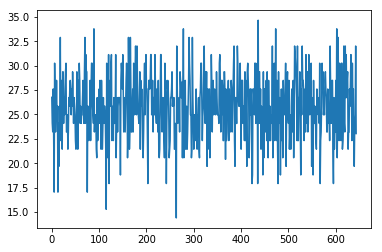

In [17]:
plt.plot(history)

In [18]:
correct, y_pred, y_true = 0, list(), list()

for image, labels in test_feeder:
    
    inputs = Variable(image.cuda()).float()
    
    
    
    
    reconstructions, classes = model(inputs)
    pred = np.argmax(classes.data.cpu().numpy())
    true = labels.numpy()[0][0].astype(np.int32)
    correct += int(pred == true)
    y_pred.append(pred)
    y_true.append(true)

In [19]:
print('Accuracy:', correct/len(test_data))

Accuracy: 0.4934725848563969


In [20]:
(np.array(y_true) == 0).sum()

174

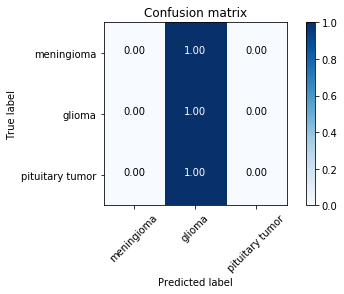

In [21]:
from sklearn.metrics import confusion_matrix
plot_confusion_matrix(cm=confusion_matrix(y_true, y_pred), classes=['meningioma','glioma','pituitary tumor'])

In [ ]:
yy = X_train['']

In [24]:
y_true[0][0]

Variable containing:
 0
[torch.cuda.LongTensor of size 1 (GPU 0)]

In [40]:
(data_resized['label'] == ).sum()

7

In [34]:
(X_train['label'] == 1).sum()

576